In [1]:
import torch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from torch.nn import Module, Linear, Sequential, Softplus
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

In [2]:
# Load the dataset. 
# molecule_features: First col is a string containing name of molecule. Rest are floats containing its features
# eutectic_compilation: First 2 cols are strings containing molecule names, third col is eutectic proportion, fourth is eutectic temperature

molecule_features = pd.read_csv("D:\\Research\\UConn_ML\\data\\eutectic_mixtures-main\\single_components.csv").drop(["xlogp"], axis=1)
eutectic_compilation = pd.read_csv("D:\\Research\\UConn_ML\\data\\eutectic_mixtures-main\\eutectic_compilation.csv")

molecule_features[molecule_features.columns[1:]] = molecule_features[molecule_features.columns[1:]].astype(float)
eutectic_compilation[eutectic_compilation.columns[3]] = eutectic_compilation[eutectic_compilation.columns[3]].astype(float)

In [3]:
# Some indices in eutectic_compilation do not exist in single_components. They will need to be removed.
# Some of the eutectic proportions are inconvertible to floats from strings. They will also need to be removed.
# missing_molecules will store all molecules that are missing features from eutectic_compilation
drops = np.array([]).astype(int)
missing_molecules = np.array([]).astype(str)
for i in range(len(eutectic_compilation)):
    ec = eutectic_compilation.iloc[i]
    m1 = ec[0]
    m2 = ec[1]
    xe = ec[2]
    
    m1f = molecule_features.loc[molecule_features.mol == ec[0]]
    m2f = molecule_features.loc[molecule_features.mol == ec[1]]
    
    try:
        xe = float(xe)
    except ValueError:
        drops = np.append(drops, i)
    
    if(len(m1f) == 0 or len(m2f) == 0):
        drops = np.append(drops, i)
        
        if(len(m1f) == 0):
            missing_molecules = np.append(missing_molecules, m1)
        elif(len(m2f) == 0):
            missing_molecules = np.append(missing_molecules, m2)

eutectic_compilation = eutectic_compilation.drop(eutectic_compilation.index[drops])
# np.savetxt("missing_molecules.csv", missing_molecules, delimiter=",", fmt="%s")

In [4]:
# Split the eutectic compilation dataframe by a ratio into training and testing sets
split = 0.95
train_ec = eutectic_compilation.sample(frac=split)
test_ec = eutectic_compilation.drop(train_ec.index)

split = 0.10
val_ec = train_ec.sample(frac=split)
train_ec = train_ec.drop(val_ec.index)

In [5]:
molecule_features

,mol,molecular_weight,complexity,rotatable_bond_count,heavy_atom_count,topological_area
0,BaO,153.3300,2.0,0.0,2.0,17.1
1,CrCl3,158.3500,0.0,0.0,4.0,0.0
2,PBr5,430.4900,37.1,0.0,6.0,0.0
3,WCl5,361.1000,37.1,0.0,6.0,0.0
4,HgI2,454.4000,2.8,0.0,3.0,0.0
...,...,...,...,...,...,...
672,PBr3,270.6900,8.0,0.0,4.0,0.0
673,PbSiO3,283.0000,18.8,0.0,5.0,63.2
674,LiI,133.9000,2.0,0.0,2.0,0.0
675,EuF3,208.9590,8.0,0.0,4.0,0.0


In [6]:
train_ec

,molA,molB,xe,Te
4453,CeO2,ZrO2,60,2300.0
4269,SiO2,ZrO2,95,1705.0
2625,CrCl3,CsCl,5.5,623.0
409,AlCl3,WCl5,70,158.0
3891,SrCl2,SrO,72,950.0
...,...,...,...,...
2686,KBr,TiBr3,80,635.0
3425,CaF2,LiF,22,760.0
903,AgCl,CsCl,72,258.0
994,NaOH,Na2S,95.7,280.0


In [7]:
val_ec

,molA,molB,xe,Te
2133,CaCl2,CfCl2,15.5,540.0
2253,SrI2,Sr3N2,75,560.0
2268,KBr,SrBr2,18,562.0
1633,PbCl2,SnS,82.6,440.0
3881,BaCl2,BaF2,22,940.0
...,...,...,...,...
2451,CaCl2,KCl,25.7,594.0
834,PbS,SnS,17,240.0
3427,KF,YF3,87,760.0
3505,K2O,SiO2,42.5,780.0


In [8]:
test_ec

,molA,molB,xe,Te
3,BCl3,PCl3,94,-110.0
4,BCl3,PCl3,20,-99.0
16,NH3,NH4NO3,96,-79.5
34,S2Br2,SnBr4,95.5,-47.5
68,ICl,SeCl4,80,16.0
...,...,...,...,...
4374,MgO,PuO2,43,1985.0
4408,MgO,ZrO2,65,2080.0
4423,La2O3,Sc2O3,26,2110.0
4448,CeO2,Cr2O3,54,2260.0


In [9]:
print(molecule_features.columns)
print(eutectic_compilation.columns)

Index(['mol', 'molecular_weight', 'complexity', 'rotatable_bond_count',
       'heavy_atom_count', 'topological_area'],
      dtype='object')
Index(['molA', 'molB', 'xe', 'Te'], dtype='object')


In [10]:
print(molecule_features.dtypes)
print(eutectic_compilation.dtypes)

mol                      object
molecular_weight        float64
complexity              float64
rotatable_bond_count    float64
heavy_atom_count        float64
topological_area        float64
dtype: object
molA     object
molB     object
xe       object
Te      float64
dtype: object


In [11]:
molecule_features.iloc[0]

mol                        BaO
molecular_weight        153.33
complexity                 2.0
rotatable_bond_count       0.0
heavy_atom_count           2.0
topological_area          17.1
Name: 0, dtype: object

In [12]:
print("Train Size: ", len(train_ec))
print("Validation Size: ", len(val_ec))
print("Test Size: ", len(test_ec))

Train Size:  3403
Validation Size:  378
Test Size:  199


In [13]:
# SNN class with model
class SiameseNeuralNetwork(Module):
    def __init__(self, start_features):
        super(SiameseNeuralNetwork, self).__init__()
        
        self.fc = Linear(in_features=3, out_features=1, bias=False) # final stage where prediction is made
        
        self.model = Sequential(
            Linear(in_features=start_features, out_features=4, bias=False),
            Softplus(),
            Linear(in_features=4, out_features=3, bias=False),
            Softplus()
        )

    def forward(self, x1, x2, marker):
        if marker == "xe":
            return self.xe(x1, x2)
        elif marker == "Te":
            return self.te(x1, x2)
        
    def xe(self, x1, x2):
        y1 = self.model(x1)
        
        # implementing f(A,B) = 1 - f(B,A)
        self.model[2].weight = torch.nn.Parameter(-1 * self.model[2].weight) # negate the weights          
        
        y2 = self.model(x2)   
        
        self.model[2].weight = torch.nn.Parameter(-1 * self.model[2].weight) # restore the weights back 
        
        d = y1 - y2                      # difference for xe
        p = torch.sigmoid(self.fc(d))    # output for xe
        return p
    
    def te(self, x1, x2):
        y1 = self.model(x1)
        y2 = self.model(x2)   
        d = torch.abs(y1 - y2)           # difference for Te
        p = self.fc(d)                   # output for Te
        return p

In [14]:
class MakeDataset(Dataset):
    def __init__(self, ec_df, mf_df, num_features):
        self.ecdf = ec_df
        self.mfdf = mf_df
        self.nf = num_features

    def __len__(self):
        return len(self.ecdf)
  
    def __getitem__(self, idx):
        ec = self.ecdf.iloc[idx]
        
        m1f = torch.tensor(np.array(self.mfdf.loc[self.mfdf.mol == ec[0]])[0][1:self.nf+1].astype(float))
        m2f = torch.tensor(np.array(self.mfdf.loc[self.mfdf.mol == ec[1]])[0][1:self.nf+1].astype(float))
        xe = torch.tensor(float(ec[2]))
        Te = torch.tensor(ec[3])
        
        return m1f, m2f, xe, Te

In [15]:
# define parameters for training
starting_features = 5
batchsize = 25
train_dset = MakeDataset(train_ec, molecule_features, starting_features)
val_dset = MakeDataset(val_ec, molecule_features, starting_features)
test_dset = MakeDataset(test_ec, molecule_features, starting_features)

Epoch 1 | Train Loss: 20.662 | Train Baseline: 35.255 | Val Loss: 1.757 | Val Baseline: 3.947
Epoch 2 | Train Loss: 14.206 | Train Baseline: 35.413 | Val Loss: 1.48 | Val Baseline: 4.229
Epoch 3 | Train Loss: 12.597 | Train Baseline: 35.178 | Val Loss: 1.362 | Val Baseline: 4.213
Epoch 4 | Train Loss: 11.915 | Train Baseline: 35.484 | Val Loss: 1.301 | Val Baseline: 4.132
Epoch 5 | Train Loss: 11.558 | Train Baseline: 35.383 | Val Loss: 1.368 | Val Baseline: 4.274
Epoch 6 | Train Loss: 11.41 | Train Baseline: 35.262 | Val Loss: 1.288 | Val Baseline: 3.878
Epoch 7 | Train Loss: 11.317 | Train Baseline: 35.285 | Val Loss: 1.272 | Val Baseline: 3.835
Epoch 8 | Train Loss: 11.359 | Train Baseline: 35.08 | Val Loss: 1.239 | Val Baseline: 3.916
Epoch 9 | Train Loss: 11.242 | Train Baseline: 35.235 | Val Loss: 1.221 | Val Baseline: 4.057
Epoch 10 | Train Loss: 11.241 | Train Baseline: 35.515 | Val Loss: 1.215 | Val Baseline: 4.11


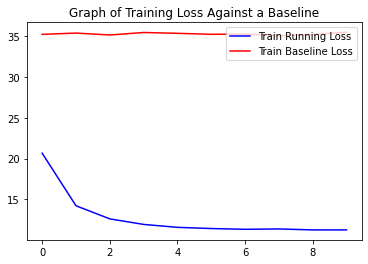

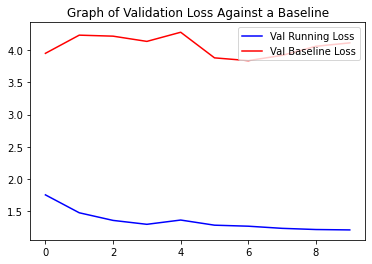

Test Loss: 0.691 | Test Baseline: 2.241



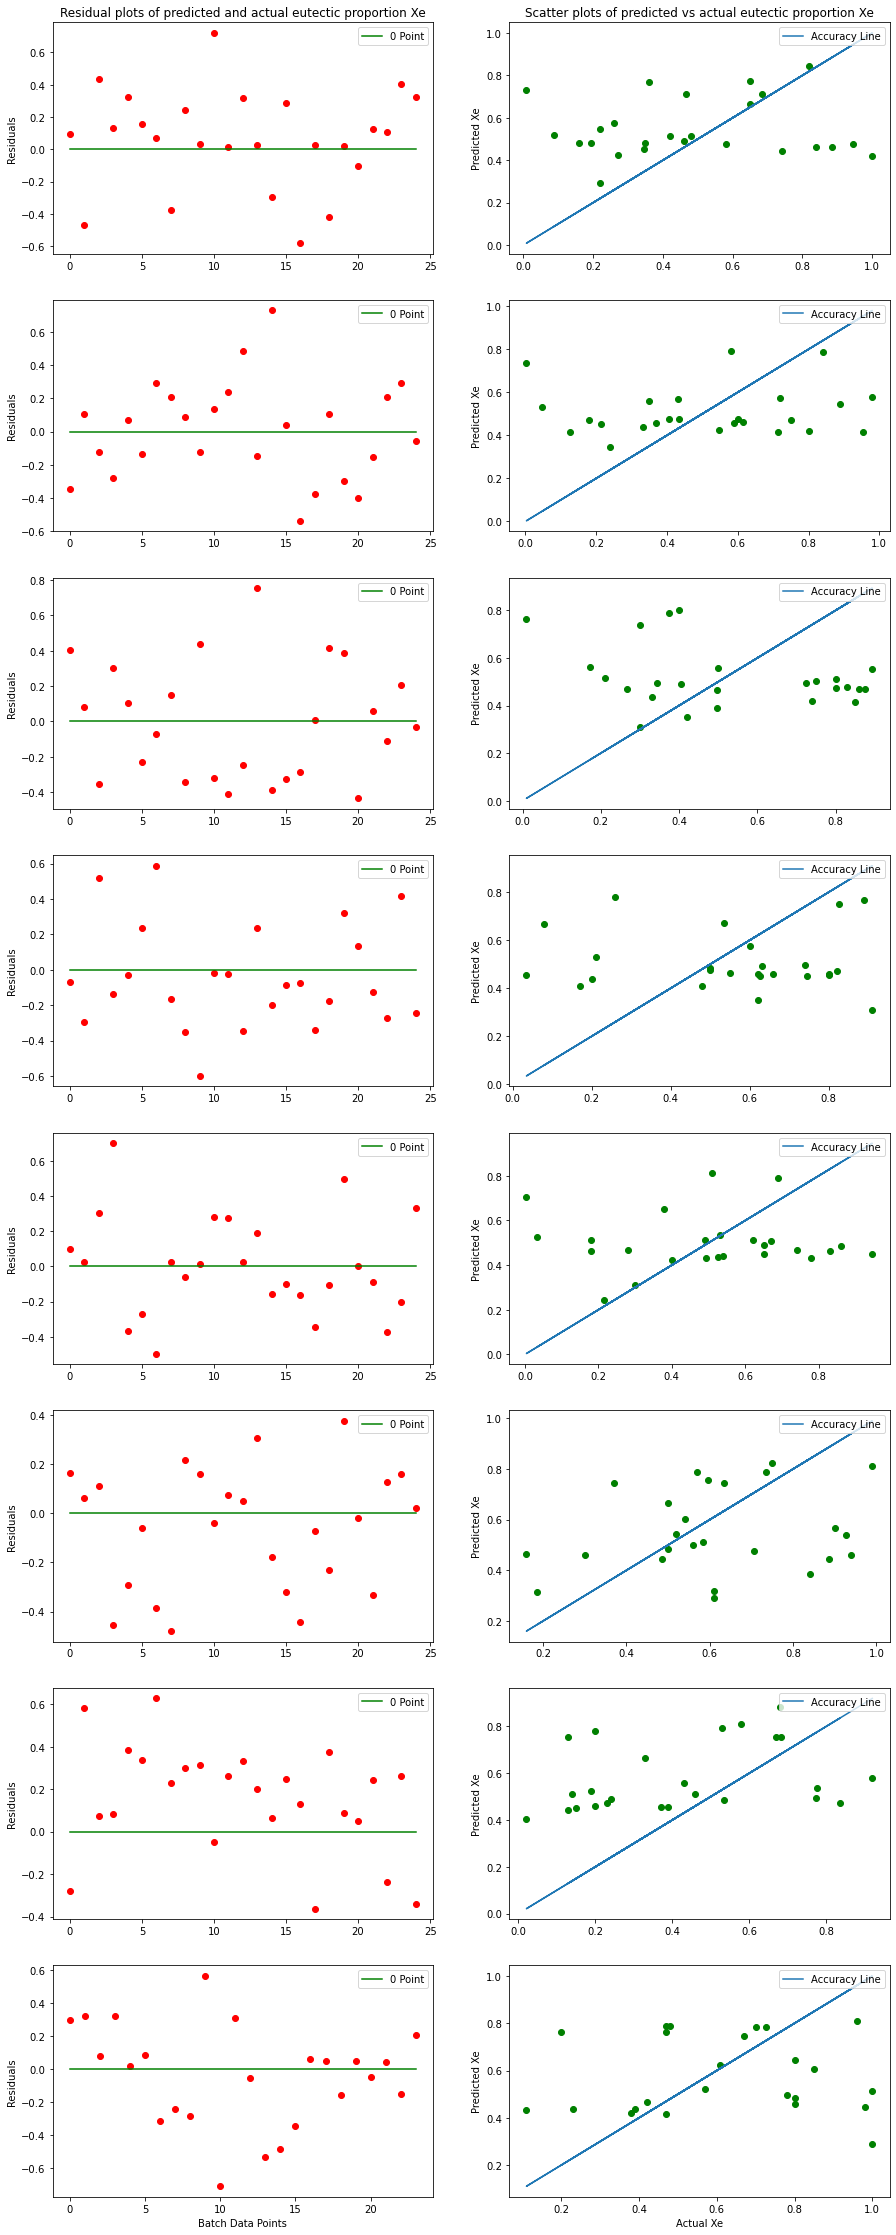

f(A,B): 
 tensor([0.7633, 0.4310, 0.7465, 0.7898, 0.6242, 0.7843, 0.4829, 0.6061, 0.4964,
        0.7622, 0.2905, 0.7898, 0.4141, 0.4456, 0.5146, 0.4569, 0.7836, 0.4680,
        0.6428, 0.4370, 0.5208, 0.4206, 0.8087, 0.4352])


f(B,A): 
 tensor([0.3631, 0.3302, 0.6807, 0.4306, 0.5754, 0.4360, 0.4627, 0.4903, 0.4441,
        0.7134, 0.3932, 0.4306, 0.7956, 0.4345, 0.5922, 0.5182, 0.3634, 0.4749,
        0.4520, 0.5113, 0.4499, 0.7410, 0.4299, 0.8007])


f(A,B) + f(B,A): 
 tensor([1.1264, 0.7612, 1.4271, 1.2204, 1.1995, 1.2203, 0.9456, 1.0964, 0.9405,
        1.4756, 0.6837, 1.2204, 1.2097, 0.8802, 1.1068, 0.9751, 1.1470, 0.9428,
        1.0948, 0.9484, 0.9708, 1.1615, 1.2385, 1.2359])


Original Values: 
 tensor([0.4700, 0.1100, 0.6700, 0.4700, 0.6080, 0.7000, 0.8000, 0.8500, 0.7800,
        0.2000, 1.0000, 0.4800, 0.4700, 0.9800, 0.9980, 0.8000, 0.7260, 0.4200,
        0.8000, 0.3900, 0.5700, 0.3800, 0.9600, 0.2300])


Predicted Values: 
 tensor([0.7633, 0.4310, 0.7465, 0.7898, 0.6242

In [16]:
# For Xe
train_ec_dl = DataLoader(train_dset, shuffle=True, batch_size=batchsize)
val_ec_dl = DataLoader(val_dset, shuffle=True, batch_size=batchsize)
test_ec_dl = DataLoader(test_dset, shuffle=True, batch_size=batchsize)

# Set the model and training parameters
model = SiameseNeuralNetwork(starting_features)
num_epochs = 10
learn_rate = 1.35e-4

# Set optimizer and loss function. Using MSE for regression.
opt = torch.optim.SGD(model.parameters(), lr=learn_rate)
criterion = torch.nn.MSELoss()

# Set the baselines for training, validation, and testing
# MSE is basically variance, so the baseline is the variance of the dataset
train_base_xe = torch.std(torch.tensor(np.array(train_ec["xe"]).astype(float) / 100.0))**2
val_base_xe = torch.std(torch.tensor(np.array(val_ec["xe"]).astype(float) / 100.0))**2
test_base_xe = torch.std(torch.tensor(np.array(test_ec["xe"]).astype(float) / 100.0))**2

###################################### Training ######################################
trloss = np.array([])
trbase = np.array([])
vloss = np.array([])
vbase = np.array([])
for epoch in range(num_epochs):
    model.train()
    train_running_loss = 0.0
    train_base_loss = 0.0
    val_running_loss = 0.0
    val_base_loss = 0.0

    # training step: iterate through the batch and obtain the 4 data
    for x, (m1, m2, xe, Te) in enumerate(train_ec_dl):   
        opt.zero_grad()
        xe = xe/100.0
        
        # pass 2 sets of inputs into the snn and get p, the output
        output = model(m1.float(), m2.float(), "xe")
        
        loss = criterion(output[:, 0], xe)
        
        base = torch.full((len(xe),), train_base_xe)     # create same value array
        base_loss = criterion(base, xe)                  # obtain baseline loss

        loss.backward()
        opt.step()

        train_running_loss += loss.item()
        train_base_loss += base_loss.item()
    
    model.eval()
    for v, (m1, m2, xe, Te) in enumerate(val_ec_dl):
        xe = xe/100.0
        
        output = model(m1.float(), m2.float(), "xe")
        val_running_loss += criterion(output[:, 0], xe).item()
        
        base = torch.full((len(xe), ), val_base_xe)
        val_base_loss += criterion(base, xe).item()
        

    print('Epoch {} | Train Loss: {} | Train Baseline: {} | Val Loss: {} | Val Baseline: {}'.format(
        epoch+1, 
        np.round(train_running_loss, 3), 
        np.round(train_base_loss, 3), 
        np.round(val_running_loss, 3), 
        np.round(val_base_loss, 3)))
    
    trloss = np.append(trloss, train_running_loss)
    trbase = np.append(trbase, train_base_loss)
    vloss = np.append(vloss, val_running_loss)
    vbase = np.append(vbase, val_base_loss)

x = np.arange(num_epochs)
plt.figure(1)
plt.plot(x, trloss, label="Train Running Loss", c="blue")
plt.plot(x, trbase, label="Train Baseline Loss", c="red")
plt.title("Graph of Training Loss Against a Baseline")
plt.legend(loc="upper right")
plt.show()

plt.figure(2)
plt.plot(x, vloss, label="Val Running Loss", c="blue")
plt.plot(x, vbase, label="Val Baseline Loss", c="red")
plt.title("Graph of Validation Loss Against a Baseline")
plt.legend(loc="upper right")
plt.show()

###################################### Testing and Plotting ###################################### 
test_loss = 0.0
test_baseline = 0.0
model.eval()

fig, axes = plt.subplots(8, 2)
fig.set_figheight(40)
fig.set_figwidth(15)
row = 0
col = 0

with torch.no_grad():
    for y, (m1, m2, xe, Te) in enumerate(test_ec_dl):
        xe = xe/100.0

        outputs = model(m1.float(), m2.float(), "xe")
        invouts = model(m2.float(), m1.float(), "xe")

        test_loss += criterion(outputs[:, 0], xe).item()

        base = torch.full((len(xe),), test_base_xe)
        test_baseline += criterion(base, xe).item()

        x = np.arange(len(xe))

        axes[row, col].scatter(x, outputs.detach().numpy() - xe[np.newaxis].numpy().T, c="red")
        axes[row, col].plot(x, np.zeros((len(xe.numpy()),)), c="green", label="0 Point")
        axes[row, 0].set(ylabel="Residuals")
        axes[row, col].legend(loc="upper right")

        axes[row, col+1].scatter(xe.numpy(), outputs.detach().numpy(), c="green")
        axes[row, col+1].plot(xe.numpy(), xe.numpy(), label="Accuracy Line")
        axes[row, 1].set(ylabel="Predicted Xe")
        axes[row, col+1].legend(loc="upper right")

        row += 1
        if row == 8:
            break

    print('Test Loss: {} | Test Baseline: {}\n'.format(
        np.round(test_loss, 3), 
        np.round(test_baseline, 3)))

    axes[-1, 0].set(xlabel="Batch Data Points")
    axes[-1, 1].set(xlabel="Actual Xe")
    axes[0, 0].set_title("Residual plots of predicted and actual eutectic proportion Xe")
    axes[0, 1].set_title("Scatter plots of predicted vs actual eutectic proportion Xe")
    plt.show()

    # fig.savefig('D:\\Research\\UConn_ML\\Images\\snn_results_plots.png')
    
# should all be 1 or close to 1 to show that f(A,B) = 1 - f(B,A)
print("f(A,B): \n", outputs.flatten())
print("\n")
print("f(B,A): \n", invouts.flatten())
print("\n")
l = min(len(outputs), len(invouts))
print("f(A,B) + f(B,A): \n", outputs[0:l].flatten() + invouts[0:l].flatten())
print("\n")
print("Original Values: \n", xe)
print("\n")
print("Predicted Values: \n", outputs.flatten())